In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from ase.io import read
from ase import Atoms
from ase.build import surface
from abtem import *

device  = 'gpu'

from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)

# Generalizations to the Ptychographic Iterative Engine

In general, ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations we'll consider are given by:
1. Form the exit wave using current object and probe estimates
2. Modify its Fourier amplitude using measured diffraction intensities
3. Update the current object and (optionally) probe estimates using the modified exit wave

Here, we review the following extensions:

i. [Regularized ePIE](https://doi.org/10.1364/OPTICA.4.000736)  
ii. Simultaneous reconstruction of the electrostatic and magnetic vector potential objects  
iii. [Mixed-States PIE](https://doi.org/10.1038/s41467-020-16688-6)  
iv. [Multislice PIE](https://doi.org/10.1364/JOSAA.29.001606)



## Electrostatic and Magnetic Vector Potential Phase Contributions

We wish to reconstruct the electrostatic potential and out-of-plane magnetic vector potential contributions to the Aharonov-Bohm phase shift given by:

$$
\begin{align}
    \phi(\boldsymbol{r}_\bot) &= \phi_e(\boldsymbol{r}_\bot)+\phi_m(\boldsymbol{r}_\bot) \notag \\
    &= \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz -\frac{e}{\hbar}\int_L\boldsymbol{A}(\boldsymbol{r}_{\bot},z)\cdot d\boldsymbol{r}
\end{align}
$$

These enter the multislice transmission function as follows:

$$
\begin{aligned}
T &= \exp{\left[-i \sigma V(r)\right]} \times \exp{\left[-i A(r)\right]} \\
  &= \exp{\left[-i \sigma \left[ V(r) + A(r)/\sigma \right]\right]}
\end{aligned}
$$

As such, we will 'hijack' the `PotentialArray` object to model a dummy magnetic vector potential.  
_Note:_ we'll need to divide by the interaction parameter $\sigma$, to ensure our hack works properly.

For the electrostatic potential, we consider a (thin) slab of [110] STO:

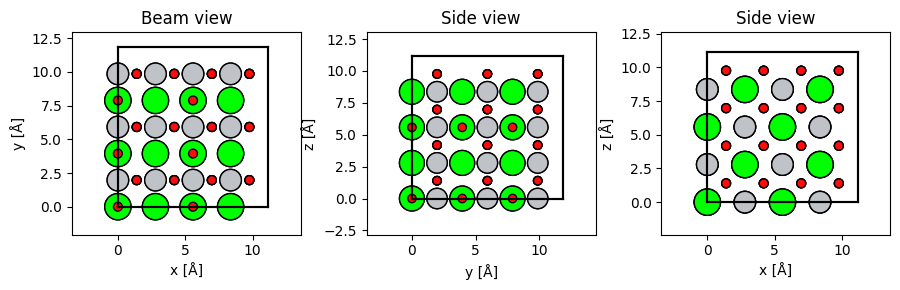

In [2]:
STO_unit_cell   = read('abtem-data/SrTiO3.cif')
STO_atoms       = surface(STO_unit_cell, (1,1,0), 4, periodic=True)*(2,3,1)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))

show_atoms(STO_atoms, ax = ax1, title = 'Beam view')
show_atoms(STO_atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(STO_atoms, ax = ax3, plane = 'xz', title = 'Side view')

fig.tight_layout();

We'll use `FrozenPhonons` to broaden our potentials to simulate finite temperature.

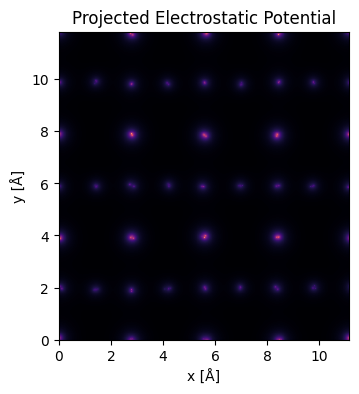

In [3]:
frozen_phonons  = FrozenPhonons(STO_atoms, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
potential       = Potential(frozen_phonons,
                            sampling=0.0125,
                            device=device,
                            projection='infinite',
                            parametrization='kirkland').build()

potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential');

For the dummy magnetic vector potential, we'll use two gaussians with opposite sign and asymmetric amplitudes:

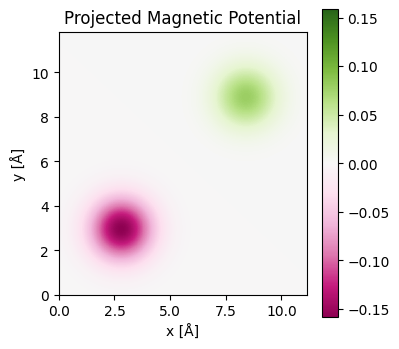

In [4]:
from cupyx.scipy.special import erf
from abtem.measure import Calibration

def projected_gaussian_potential(x,y,
                                 z0=10.,z1=0.,
                                 l=10.,w=10.,t=10.,
                                 sigma=1.,asymmetry=2.):
    return (
        asymmetry*(
            cp.exp(-((w-4*y)**2+(l-4*x)**2)/(32*sigma**2))*(
                erf((t-4*z0)/(4*cp.sqrt(2)*sigma))-
                erf((t-4*z1)/(4*cp.sqrt(2)*sigma))
            )
        )+(
            cp.exp(-(9*l**2+9*w**2-24*l*x - 24*w*y+16*(x**2+y**2))/(32*sigma**2))*(
                erf((4*z0-3*t)/(4*cp.sqrt(2)*sigma))-
                erf((4*z1-3*t)/(4*cp.sqrt(2)*sigma))
            )
        )
    )/(4*asymmetry*cp.pi*sigma**2)

def match_grid(potential):
    gx, gy    = potential.gpts
    lx, ly    = potential.extent

    return cp.meshgrid(
        cp.linspace(0.,lx,gx,endpoint=False),
        cp.linspace(0.,ly,gy,endpoint=False),
        indexing='ij'
    )

def get_cumulative_thicknesses(potential):
    return np.flipud(np.cumsum(np.insert(potential.slice_thicknesses,0,0)))


projected_gaussian_calibrations = tuple(Calibration(0., d, 'Å', name, endpoint=False) 
                                        for name, d in zip(('x','y'),potential.sampling))

x,y                             = match_grid(potential)
l,w,t                           = STO_atoms.cell.lengths()
projected_gaussian_measurement  = Measurement(projected_gaussian_potential(x,y,
                                                                           z0=t,z1=0,
                                                                           l=l,w=w,t=t,
                                                                           sigma=1.0,asymmetry=2.
                                                                          ),
                                              projected_gaussian_calibrations)

cmin                            = np.amin(projected_gaussian_measurement.array)
projected_gaussian_measurement.show(cmap='PiYG',cbar=True,vmin=cmin,vmax=-cmin,figsize=(4,4),
                                    title='Projected Magnetic Potential');

cumulative_thicknesses                = get_cumulative_thicknesses(potential)
magnetic_potential                    = cp.empty(potential.array.shape)

for slice_id in range(potential.num_slices):
    magnetic_potential[slice_id] = projected_gaussian_potential(x,y,
                                                                z0=cumulative_thicknesses[slice_id],
                                                                z1=cumulative_thicknesses[slice_id+1],
                                                                l=l,w=w,t=t,
                                                                sigma=1.0,asymmetry=2.)


## 4DSTEM Simulations

We'll use a fairly aberrated probe:

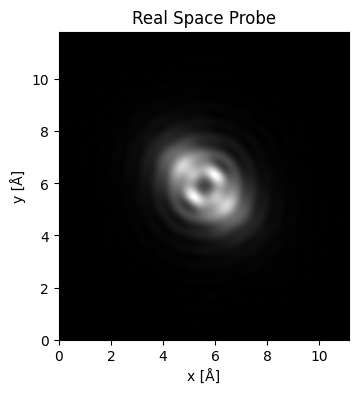

In [5]:
from abtem.utils import energy2sigma


ctf             = CTF(parameters={'C10': -75,'C12': 20, 'phi12': 0.785,'C30':-7e4},semiangle_cutoff=24)
S               = SMatrix(interpolation=1,
                          energy=200e3,
                          expansion_cutoff=28,
                          ctf=ctf,
                          downsample=False,
                          device=device)

S.match_grid(potential)

magnetic_potential /= energy2sigma(S.energy)
pixelated_detector  = PixelatedDetector(max_angle=120)
gridscan            = GridScan((0,0),
                               potential.extent,
                               sampling = 0.9*S.ctf.nyquist_sampling)


S.show(figsize=(4,4),title='Real Space Probe');

We'll perform three 4DSTEM simulations:
1. One with only the electrostatic potential ('measurement_off')
2. One with a positive magnetic vector potenial ('measurement_forward')
3. One with a negative magnetic vector potential ('measuremetn_reverse')

In [6]:
modified_potential_forward         = potential.copy()
modified_potential_forward._array += magnetic_potential

measurement_forward                = S.scan(gridscan,
                                            pixelated_detector,
                                            modified_potential_forward)

modified_potential_off             = potential.copy()

measurement_off                    = S.scan(gridscan,
                                            pixelated_detector,
                                            modified_potential_off)

modified_potential_reverse         = potential.copy()
modified_potential_reverse._array -= magnetic_potential

measurement_reverse                = S.scan(gridscan,
                                            pixelated_detector,
                                            modified_potential_reverse)

Multislice:   0%|          | 0/523 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

Multislice:   0%|          | 0/523 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

Multislice:   0%|          | 0/523 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

We can check how our HAADF looks like for the case with no magnetic vector-potential.  
_Note_: the magnetic vector potential contribution is too tiny to visibly appear in the HAADF - Try it!

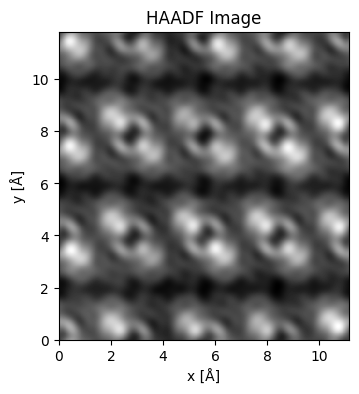

In [7]:
haadf_detector_measurement_off   = AnnularDetector(inner=24,outer=120).integrate(measurement_off)
haadf_detector_measurement_off   = haadf_detector_measurement_off.interpolate(potential.sampling)

haadf_detector_measurement_off.show(figsize=(4,4),title='HAADF Image');

## 1. (Regularized) extended PIE:

We first try using (mostly) vanilla e-PIE. If you're curious, the difference between the original e-PIE is in the regularization of the update step.
$\alpha = 1, \beta = 1$ corresponds to e-PIE with $\alpha = 1, \beta=1$, while $\alpha, \beta \rightarrow 0$ corresponds to typical gradient descent.

- Exit wave:
$$
\psi_{j \boldsymbol{r}} = P_{\boldsymbol{r}} \times O_{\boldsymbol{r}-\boldsymbol{R}_j}
$$
- Amplitude modification:
$$
\psi'_{j \boldsymbol{r}} = \mathcal{F}^{-1} \left[\sqrt{I_{j \boldsymbol{q}}} \frac{\mathcal{F}\left[ \psi_{j \boldsymbol{r}}\right]}{ \left| \mathcal{F}\left[ \psi_{j \boldsymbol{r}}\right] \right|} \right]
$$
- Update rules:
$$
\begin{aligned}
O'_{\boldsymbol{r}-\boldsymbol{R}_j} &= O_{\boldsymbol{r}-\boldsymbol{R}_j} +  \frac{P^*_{\boldsymbol{r}}}{\left(1-\alpha\right)|P_{\boldsymbol{r}}|^2 + \alpha|P_{\boldsymbol{r}}|^2_{max}} \left(\psi'_{j \boldsymbol{r}} - \psi_{j \boldsymbol{r}} \right) \\
P'_{\boldsymbol{r}} &= P_{\boldsymbol{r}} + \frac{O^*_{\boldsymbol{r}-\boldsymbol{R}_j}}{\left(1-\beta\right)|O_{\boldsymbol{r}-\boldsymbol{R}_j}|^2 + \beta|O_{\boldsymbol{r}-\boldsymbol{R}_j}|^2_{max}} \left(\psi'_{j \boldsymbol{r}} - \psi_{j \boldsymbol{r}} \right)
\end{aligned}
$$

We'll need an initial probe guess. We'll assume we only know the energy and semiangle of the probe, and see if the reconstruction can correct for aberrations:

In [8]:
from abtem.reconstruct import ptychographic_reconstruction
probe_guess = Probe(energy=200e3,semiangle_cutoff=24)

objects_epie, probes_epie, sse_epie = ptychographic_reconstruction(measurement_off,
                                                                   probe_guess,
                                                                   maxiter = 5,
                                                                   return_iterations= True,
                                                                   verbose = True,
                                                                   fix_com=True,
                                                                   seed = 1,
                                                                   device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 1.736e-06
Iteration 1, SSE = 1.532e-07
Iteration 2, SSE = 7.974e-08
Iteration 3, SSE = 7.572e-08
Iteration 4, SSE = 7.467e-08


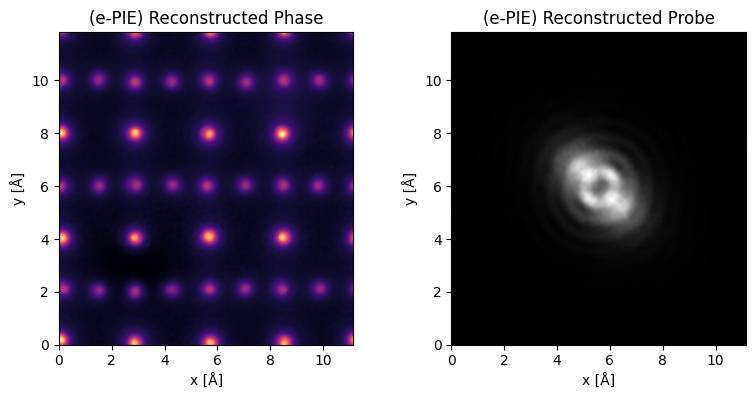

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_epie[-1].angle().interpolate(potential.sampling).show(cmap='magma',ax=ax1,
                                                              title='(e-PIE) Reconstructed Phase')
probes_epie[-1].intensity().interpolate(potential.sampling).show(ax=ax2,title='(e-PIE) Reconstructed Probe')

fig.tight_layout();

This is already excellent, the regularized e-PIE algorithm is effectively converged after only 5 iterations and has corrected all aberrations!

_Quick note:_ You can also re-start reconstructions by passing the last probe and object arrays back to the `ptychographic_reconstruction` function like so:

```
ptychographic_reconstruction(measurement_off,
                             probes_epie[-1].array,
                             object_guesses=objects_epie[-1].array,
                             energy=probe_guess.energy,
                             maxiter = 5,
                             return_iterations= True,
                             #verbose = True,
                             fix_com=True,
                             seed = 1,
                             device = device)
```

## 2. Simultaneous reconstruction PIE

In theory, we could do two independent ePIE reconstructions for `measurement_forward` and `measurement_reverse` and then use the following equation to separate the electrostatic and magnetic phase contributions:

$$
\begin{aligned}
\phi_e &= \left(\phi^{(\mathrm{forward})} + \phi^{(\mathrm{reverse})}\right)/2 \\
\phi_m &= \left(\phi^{(\mathrm{forward})} - \phi^{(\mathrm{reverse})}\right)/2
\end{aligned}
$$

In [10]:
objects_epie_forward, probes_epie_forward, sse_epie_forward = ptychographic_reconstruction(measurement_forward,
                                                                                           probe_guess,
                                                                                           maxiter = 5,
                                                                                           return_iterations= True,
                                                                                           verbose = False,
                                                                                           fix_com=True,
                                                                                           seed = 1,
                                                                                           device = device)

objects_epie_reverse, probes_epie_reverse, sse_epie_reverse = ptychographic_reconstruction(measurement_reverse,
                                                                                           probe_guess,
                                                                                           maxiter = 5,
                                                                                           return_iterations= True,
                                                                                           verbose = False,
                                                                                           fix_com=True,
                                                                                           seed = 1,
                                                                                           device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

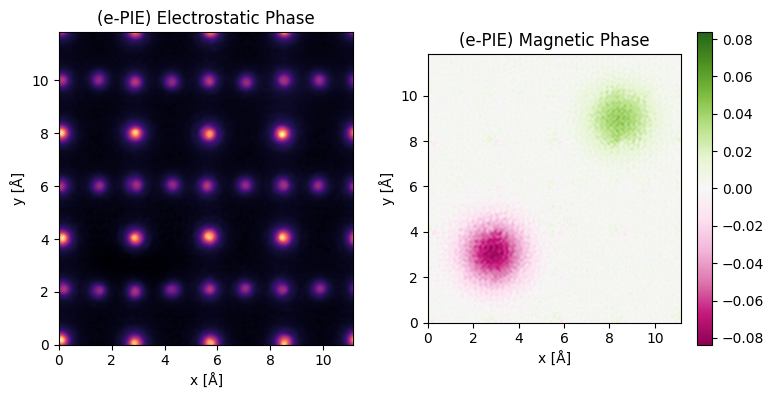

In [11]:
electrostatic_object = (objects_epie_forward[-1].angle()+objects_epie_reverse[-1].angle())/2
magnetic_object      = (objects_epie_forward[-1].angle()-objects_epie_reverse[-1].angle())/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

electrostatic_object.interpolate(potential.sampling).show(cmap='magma',
                                                          ax=ax1,title='(e-PIE) Electrostatic Phase')

cmin_subtraction = np.amin(magnetic_object.array)

magnetic_object.interpolate(potential.sampling).show(cmap='PiYG',
                                                     cbar=True,
                                                     vmin=cmin_subtraction,
                                                     vmax=-cmin_subtraction,
                                                     ax=ax2,
                                                     title='(e-PIE) Magnetic Phase')

fig.tight_layout();

This works reasonably well, however since the magnetic vector potential is so much smaller compared to the electrostatic potential - we are amplifying our noise by subtracting our two reconstructions.

Instead, since we have physics-based intuition of the forward models - we can simply modify our exit-wave and update-rule formulations to jointly-reconstruct both objects using the two sets of diffraction patterns.

- Exit waves:
$$
\begin{aligned}
\psi_{j \boldsymbol{r}} &= P_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M_{\boldsymbol{r}-\boldsymbol{R}_j} \\
\phi_{j \boldsymbol{r}} &= P_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M^*_{\boldsymbol{r}-\boldsymbol{R}_j}
\end{aligned}
$$
- Amplitude modification:
$$
\begin{aligned}
\psi'_{j \boldsymbol{r}} &= \mathcal{F}^{-1} \left[\sqrt{I_{j \boldsymbol{q}}} \frac{\mathcal{F}\left[ \psi_{j \boldsymbol{r}}\right]}{ \left| \mathcal{F}\left[ \psi_{j \boldsymbol{r}}\right] \right|} \right] \\
\phi'_{j \boldsymbol{r}} &= \mathcal{F}^{-1} \left[\sqrt{\Omega_{j \boldsymbol{q}}} \frac{\mathcal{F}\left[ \phi_{j \boldsymbol{r}}\right]}{ \left| \mathcal{F}\left[ \phi_{j \boldsymbol{r}}\right] \right|} \right]
\end{aligned}
$$
- Update rules:
$$
\begin{aligned}
V'_{\boldsymbol{r}-\boldsymbol{R}_j} &= V_{\boldsymbol{r}-\boldsymbol{R}_j} +  \frac{1/2}{\left(1-\alpha\right)|P_{\boldsymbol{r}} M_{\boldsymbol{r}-\boldsymbol{R}_j}|^2 + \alpha|P_{\boldsymbol{r}} M_{\boldsymbol{r}-\boldsymbol{R}_j}|^2_{max}} \left[ P^*_{\boldsymbol{r}} M^*_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \psi'_{j \boldsymbol{r}} - \psi_{j \boldsymbol{r}} \right) + P^*_{\boldsymbol{r}} M_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \phi'_{j \boldsymbol{r}} - \phi_{j \boldsymbol{r}} \right)  \right] \\
M'_{\boldsymbol{r}-\boldsymbol{R}_j} &= M_{\boldsymbol{r}-\boldsymbol{R}_j} +  \frac{1/2}{\left(1-\alpha\right)|P_{\boldsymbol{r}} V_{\boldsymbol{r}-\boldsymbol{R}_j}|^2 + \alpha|P_{\boldsymbol{r}} V_{\boldsymbol{r}-\boldsymbol{R}_j}|^2_{max}} \left[ P^*_{\boldsymbol{r}} V^*_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \psi'_{j \boldsymbol{r}} - \psi_{j \boldsymbol{r}} \right) - P^*_{\boldsymbol{r}} V^*_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \phi'_{j \boldsymbol{r}} - \phi_{j \boldsymbol{r}} \right)  \right] \\
P'_{\boldsymbol{r}} &= P_{\boldsymbol{r}} +  \frac{1/2}{\left(1-\beta\right)|V_{\boldsymbol{r}-\boldsymbol{R}_j} M_{\boldsymbol{r}-\boldsymbol{R}_j}|^2 + \beta|V_{\boldsymbol{r}-\boldsymbol{R}_j} M_{\boldsymbol{r}-\boldsymbol{R}_j}|^2_{max}} \left[ V^*_{\boldsymbol{r}-\boldsymbol{R}_j} M^*_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \psi'_{j \boldsymbol{r}} - \psi_{j \boldsymbol{r}} \right) + V^*_{\boldsymbol{r}-\boldsymbol{R}_j} M_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \phi'_{j \boldsymbol{r}} - \phi_{j \boldsymbol{r}} \right)  \right]
\end{aligned}
$$

In [12]:
objects_simpie, probes_simpie, sse_simpie = ptychographic_reconstruction((measurement_forward,measurement_reverse),
                                                                         probe_guess,
                                                                         maxiter = 5,
                                                                         return_iterations= True,
                                                                         damping_rate=0.75,
                                                                         verbose = True,
                                                                         fix_com=True,
                                                                         seed = 1,
                                                                         device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 1.770e-06
Iteration 1, SSE = 1.525e-07
Iteration 2, SSE = 7.337e-08
Iteration 3, SSE = 5.993e-08
Iteration 4, SSE = 5.481e-08


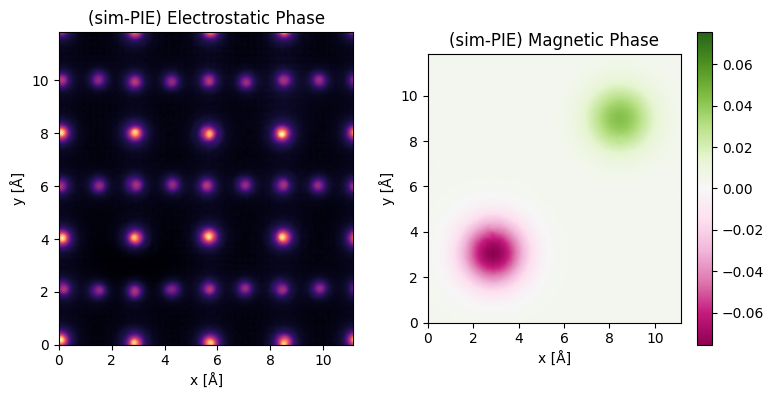

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_simpie[-1][0].angle().interpolate(potential.sampling).show(cmap='magma',
                                                                   ax=ax1,
                                                                   title='(sim-PIE) Electrostatic Phase')

cmin_simpie = np.amin(objects_simpie[-1][1].angle().array)

objects_simpie[-1][1].angle().interpolate(potential.sampling).show(cmap='PiYG',
                                                                   cbar=True,
                                                                   vmin=cmin_simpie,
                                                                   vmax=-cmin_simpie,
                                                                   ax=ax2,
                                                                   title='(sim-PIE) Magnetic Phase')

fig.tight_layout();

Considering our significant aberrations, this is quite good!

### 3. Mixed-States PIE ($K$ probes, $L$ objects)

We might be tempted to see if mixed-state ptychography can give better results.  
_Note:_ This is perhaps slightly contrived for this simulated example, but could be useful in experimental datasets:

- Exit wave (for the $k^{\text{th}}$ probe and $l^{\text{th}}$ object):
$$
\psi^{(k,l)}_{j \boldsymbol{r}} = P^k_{\boldsymbol{r}} \times O^l_{\boldsymbol{r}-\boldsymbol{R}_j}
$$
- Amplitude modification (Note this is subtly different!):
$$
\psi^{(k,l)'}_{j \boldsymbol{r}} = \mathcal{F}^{-1} \left[\sqrt{I_{j \boldsymbol{q}}} \frac{\mathcal{F}\left[ \psi^{(k,l)}_{j \boldsymbol{r}}\right]}{\sqrt{\sum_{k,l} \left| \mathcal{F}\left[\psi^{(k,l)}_{j \boldsymbol{r}}\right] \right|^2 }} \right]
$$
- Update rules:
$$
\begin{aligned}
O^{(l)'}_{\boldsymbol{r}-\boldsymbol{R}_j} &= O^{(l)}_{\boldsymbol{r}-\boldsymbol{R}_j} + \frac{1}{(1-\alpha)\sum_k \left| P^{(k)}_{\boldsymbol{r}}\right|^2 + \alpha \sum_k \left| P^{(k)}_{\boldsymbol{r}}\right|^2_{max}} \sum_k P^{(k)*}_{\boldsymbol{r}} \left( \psi^{(k,l)'}_{j \boldsymbol{r}} - \psi^{(k,l)}_{j \boldsymbol{r}} \right) \\
P^{(k)'}_{\boldsymbol{r}} &= P^{(k)}_{\boldsymbol{r}} + \frac{1}{(1-\beta)\sum_l \left| O^{(l)}_{\boldsymbol{r}-\boldsymbol{R}_j}\right|^2 + \beta \sum_l \left| O^{(l)}_{\boldsymbol{r}-\boldsymbol{R}_j}\right|^2_{max}} \sum_l O^{(l)*}_{\boldsymbol{r}-\boldsymbol{R}_j} \left( \psi^{(k,l)'}_{j \boldsymbol{r}} - \psi^{(k,l)}_{j \boldsymbol{r}} \right)
\end{aligned}
$$

In [14]:
objects_mixpie, probes_mixpie, sse_mixpie = ptychographic_reconstruction(measurement_off,
                                                                         probe_guess,
                                                                         maxiter = 5,
                                                                         num_probes=5,
                                                                         damping_rate=0.75,
                                                                         return_iterations= True,
                                                                         verbose = True,
                                                                         fix_com=True,
                                                                         seed = 1,
                                                                         device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 1.232e-04
Iteration 1, SSE = 1.219e-04
Iteration 2, SSE = 1.217e-04
Iteration 3, SSE = 1.217e-04
Iteration 4, SSE = 1.218e-04


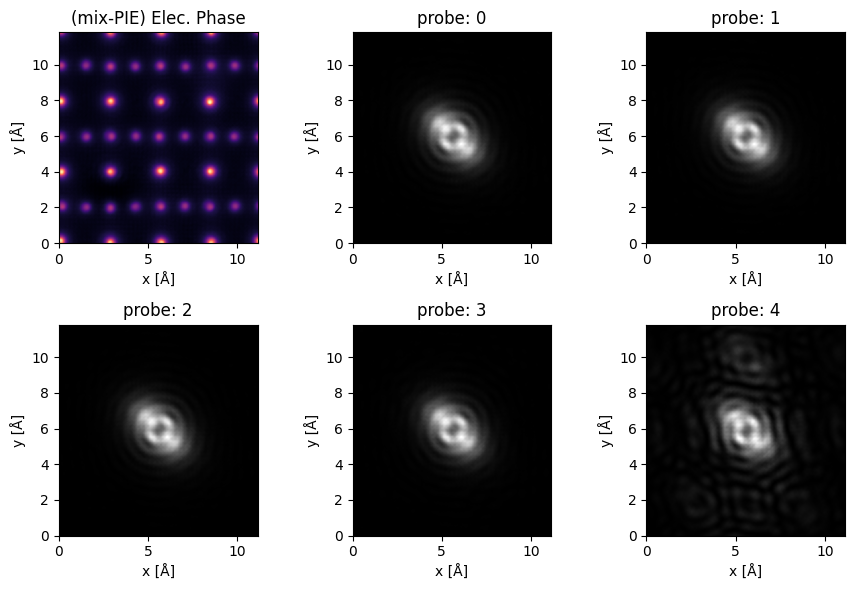

In [15]:
fig, axs = plt.subplots(2, 3, figsize = (9,6))

objects_mixpie[-1][0].angle().interpolate(potential.sampling).show(cmap='magma',ax=axs[0,0],
                                                                   title='(mix-PIE) Elec. Phase')
for k, ax in enumerate(axs.flat[1:]):
    probes_mixpie[-1][k].intensity().interpolate(potential.sampling).show(ax=ax, title="probe: {k}".format(k=k))

fig.tight_layout();

### 4. Multislice PIE ($N$ slices)

Note that while our reconstruction have largely been successful, they relied on the multiplicative assumption for our exit waves: 

$$
\psi_{j \boldsymbol{r}} = P_{\boldsymbol{r}} \times O_{\boldsymbol{r}-\boldsymbol{R}_j}
$$

This breaks down for thick samples, and multislice ptychography accounts for this using the following forward model and update rules: 

- Exit wave (for each slice $n$):
$$
\begin{aligned}
\psi_{j \boldsymbol{r}}^n &= P^n_{\boldsymbol{r}} \times O^n_{\boldsymbol{r}-\boldsymbol{R}_j} \\
P^{n+1}_{\boldsymbol{r}}  &= \mathrm{Prop}_{\Delta Z_n}\left[ \psi_{j \boldsymbol{r}}^n \right]
\end{aligned}
$$
- Amplitude modification (last slice only, $n=N$):
$$
\psi^{N'}_{j \boldsymbol{r}} = \mathcal{F}^{-1} \left[\sqrt{I_{j \boldsymbol{q}}} \frac{\mathcal{F}\left[ \psi^N_{j \boldsymbol{r}}\right]}{ \left| \mathcal{F}\left[ \psi^N_{j \boldsymbol{r}}\right] \right|} \right]
$$
- Update rules (starting from the last slice and moving up):
$$
\begin{aligned}
O^{n'}_{\boldsymbol{r}-\boldsymbol{R}_j} &= O^n_{\boldsymbol{r}-\boldsymbol{R}_j} +  \frac{P^{n*}_{\boldsymbol{r}}}{\left(1-\alpha\right)|P^n_{\boldsymbol{r}}|^2 + \alpha|P^n_{\boldsymbol{r}}|^2_{max}} \left(\psi^{n'}_{j \boldsymbol{r}} - \psi^n_{j \boldsymbol{r}} \right) \\
P^{n'}_{\boldsymbol{r}} &= P^n_{\boldsymbol{r}} + \frac{O^{n*}_{\boldsymbol{r}-\boldsymbol{R}_j}}{\left(1-\beta\right)|O^n_{\boldsymbol{r}-\boldsymbol{R}_j}|^2 + \beta|O^n_{\boldsymbol{r}-\boldsymbol{R}_j}|^2_{max}} \left(\psi^{n'}_{j \boldsymbol{r}} - \psi^n_{j \boldsymbol{r}} \right)\\
\psi^{n-1'}_{j \boldsymbol{r}} &= \mathrm{Prop}_{-\Delta Z_{n-1}}[P^{n'}_{\boldsymbol{r}}]
\end{aligned}
$$  

First, let's see e-PIE breakdown for a sample 3 times as thick (~3.5 nms)

In [16]:
STO_atoms_thick      = STO_atoms *(1,1,3)
frozen_phonons_thick = FrozenPhonons(STO_atoms_thick, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
potential_thick      = Potential(frozen_phonons_thick,
                                 sampling=0.0125,
                                 device=device,
                                 projection='infinite',
                                 parametrization='kirkland').build()

measurement_thick                = S.scan(gridscan,
                                          pixelated_detector,
                                          potential_thick)

Multislice:   0%|          | 0/523 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

In [17]:
objects_epie_thick, probes_epie_thick, sse_epie_thick = ptychographic_reconstruction(measurement_thick,
                                                                                     probe_guess,
                                                                                     maxiter = 5,
                                                                                     return_iterations= True,
                                                                                     verbose = True,
                                                                                     damping_rate=0.75,
                                                                                     fix_com=True,
                                                                                     seed = 1,
                                                                                     device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 3.934e-06
Iteration 1, SSE = 1.524e-06
Iteration 2, SSE = 1.422e-06
Iteration 3, SSE = 1.335e-06
Iteration 4, SSE = 1.266e-06


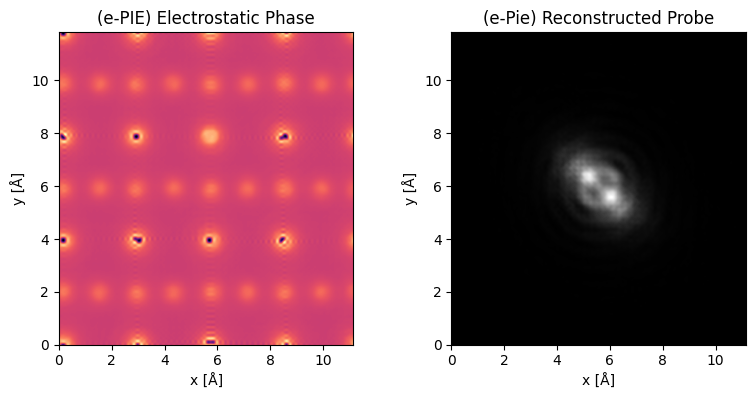

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_epie_thick[-1].angle().interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,
                                                                          title='(e-PIE) Electrostatic Phase')
probes_epie_thick[-1].intensity().interpolate(potential_thick.sampling).show(ax=ax2,title='(e-Pie) Reconstructed Probe')

fig.tight_layout();

Indeed, the e-PIE algorithm does pretty poorly on the thicker sample.  
Let's see if multislice-PIE performs better. We'll use three evenly-spaced slices:

In [20]:
objects_msepie, probes_msepie, sse_msepie = ptychographic_reconstruction(measurement_thick,
                                                                         probe_guess,
                                                                         maxiter = 5,
                                                                         num_slices=3,
                                                                         slice_thicknesses=t,
                                                                         alpha=0.5,
                                                                         return_iterations= True,
                                                                         verbose = True,
                                                                         fix_com=True,
                                                                         seed = 1,
                                                                         device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 3.453e-06
Iteration 1, SSE = 9.035e-07
Iteration 2, SSE = 4.002e-07
Iteration 3, SSE = 3.915e-07
Iteration 4, SSE = 3.854e-07


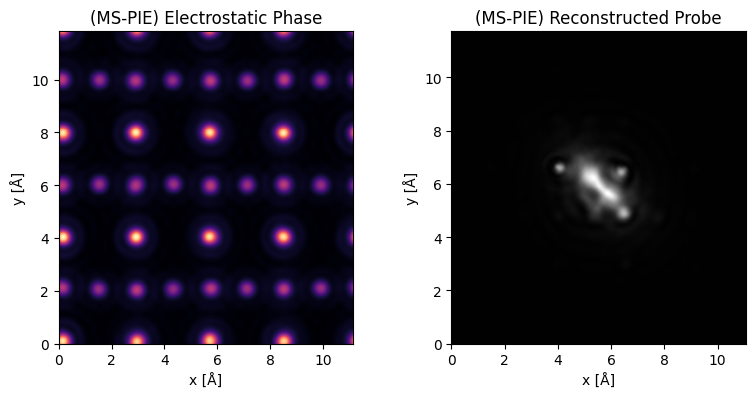

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_msepie[-1].angle().sum(0).interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,
                                                                             title='(MS-PIE) Electrostatic Phase')
probes_msepie[-1][0].intensity().interpolate(potential_thick.sampling).show(ax=ax2,
                                                                           title='(MS-PIE) Reconstructed Probe')

fig.tight_layout();

This is indeed significantly better, albeit harder to converge.

### 5. Custom exit-wave, amplitude-modification, and update-rule functions

Finally, we can also supply a custom functions dictionary, e.g. here we're using the original PIE framework for the update rule, and keeping the rest of the functions as in e-PIE:

In [23]:
def _pie_update_func(exit_wave_array:np.ndarray,
                     modified_exit_wave_array:np.ndarray,
                     object_array:np.ndarray,
                     probe_array:np.ndarray,
                     fix_probe: bool = False,
                     alpha: float = 1.,
                     beta: float = 1.,
                     damping: float = 1.,
                     xp = np,
                     **kwargs):
    
    exit_wave_diff    = modified_exit_wave_array - exit_wave_array
    probe_conj        = xp.conj(probe_array)
    obj_conj          = xp.conj(object_array)
    probe_abs         = xp.abs(probe_array)
    obj_abs           = xp.abs(object_array)
    
    object_array     += damping * probe_abs*probe_conj*exit_wave_diff / (
                        xp.max(probe_abs)*(probe_abs**2 + alpha* xp.max(probe_abs**2)))
    
    if not fix_probe:
        probe_array  += damping * obj_abs*obj_conj*exit_wave_diff / (
                        xp.max(obj_abs)*(obj_abs**2 + beta* xp.max(obj_abs**2)))
    
    return object_array, probe_array

from abtem.reconstruct import _epie_amplitude_modification_func, _epie_exit_wave_func, _update_single_probe_center_of_mass_func

pie_functions_dictionary={
    'exit_wave_func':_epie_exit_wave_func,
    'amplitude_modification_func': _epie_amplitude_modification_func,
    'update_func': _pie_update_func,
    'update_center_of_mass_func': _update_single_probe_center_of_mass_func
}

objects_pie, probes_pie, sse_pie = ptychographic_reconstruction(measurement_off,
                                                                probe_guess,
                                                                maxiter = 5,
                                                                return_iterations= True,
                                                                verbose = True,
                                                                fix_com=True,
                                                                seed = 1,
                                                                device = device,
                                                                functions_dictionary=pie_functions_dictionary)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

Iteration 0, SSE = 1.594e-06
Iteration 1, SSE = 1.091e-06
Iteration 2, SSE = 9.486e-08
Iteration 3, SSE = 6.490e-08
Iteration 4, SSE = 5.905e-08


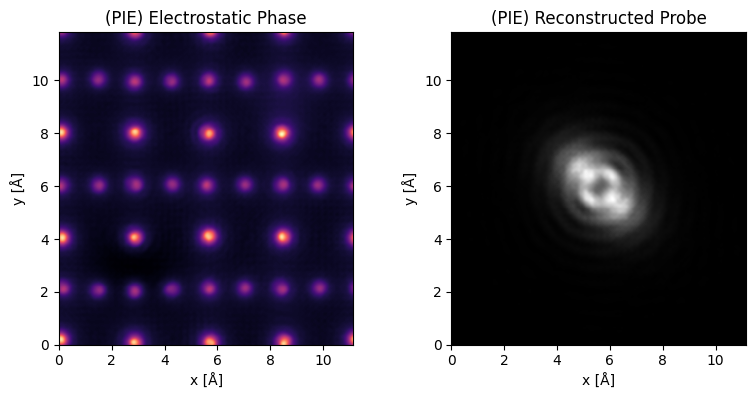

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_pie[-1].angle().interpolate(potential.sampling).show(cmap='magma',ax=ax1,
                                                            title='(PIE) Electrostatic Phase')
probes_pie[-1].intensity().interpolate(potential.sampling).show(ax=ax2,
                                                               title='(PIE) Reconstructed Probe')

fig.tight_layout();